Porto Seguro’s Safe Driver Prediction
==========================
Predict if a driver will file an insurance claim next year.
------------

4th Solution
-----------

Reference : https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

Load the data
--------

In [2]:
trainset = pd.read_csv('data/train.csv')
testset = pd.read_csv('data/test.csv')

Few quick observeations
-------

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
print('Train dataset (rows, cols) :', trainset.shape, 
      '\nTest dataset (rows, cols) :', testset.shape)

Train dataset (rows, cols) : (595212, 59) 
Test dataset (rows, cols) : (892816, 58)


In [5]:
print('Columns in train and not in test dataset :', set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset : {'target'}


Introdution to metadata
-----------

In [6]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'integer'
        
    preserve = True
    if feature == 'id':
        preserve = False
    
    dtype = trainset[feature].dtype
    
    category = 'none'
    if 'ind' in feature:
        category = 'indivisual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {
        'varname' : feature,
        'use' : use,
        'type' : type,
        'preserve' : preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns = ['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,indivisual
ps_ind_02_cat,input,categorical,True,int64,indivisual
ps_ind_03,input,categorical,True,int64,indivisual
ps_ind_04_cat,input,categorical,True,int64,indivisual
ps_ind_05_cat,input,categorical,True,int64,indivisual
ps_ind_06_bin,input,binary,True,int64,indivisual
ps_ind_07_bin,input,binary,True,int64,indivisual


In [7]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

In [8]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,indivisual,18
3,none,2
4,registration,3


In [9]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,16
3,input,integer,21
4,target,binary,1


Data analysis and statistics
-----------

### target variable

<Figure size 432x288 with 0 Axes>

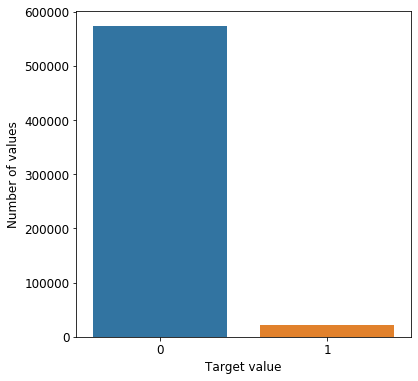

In [10]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

### real features

In [11]:
(pow(trainset['ps_car_12'] * 10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [12]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Features with missing values


### Registration features

### Car features

### Calculated features

In [21]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_01,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\default.DESKTOP-S5Q9GAA\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000014791BF5588> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

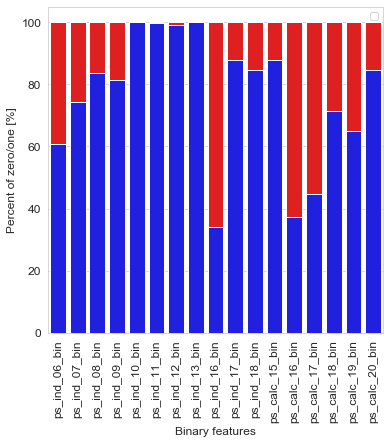

In [22]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

<Figure size 432x288 with 0 Axes>

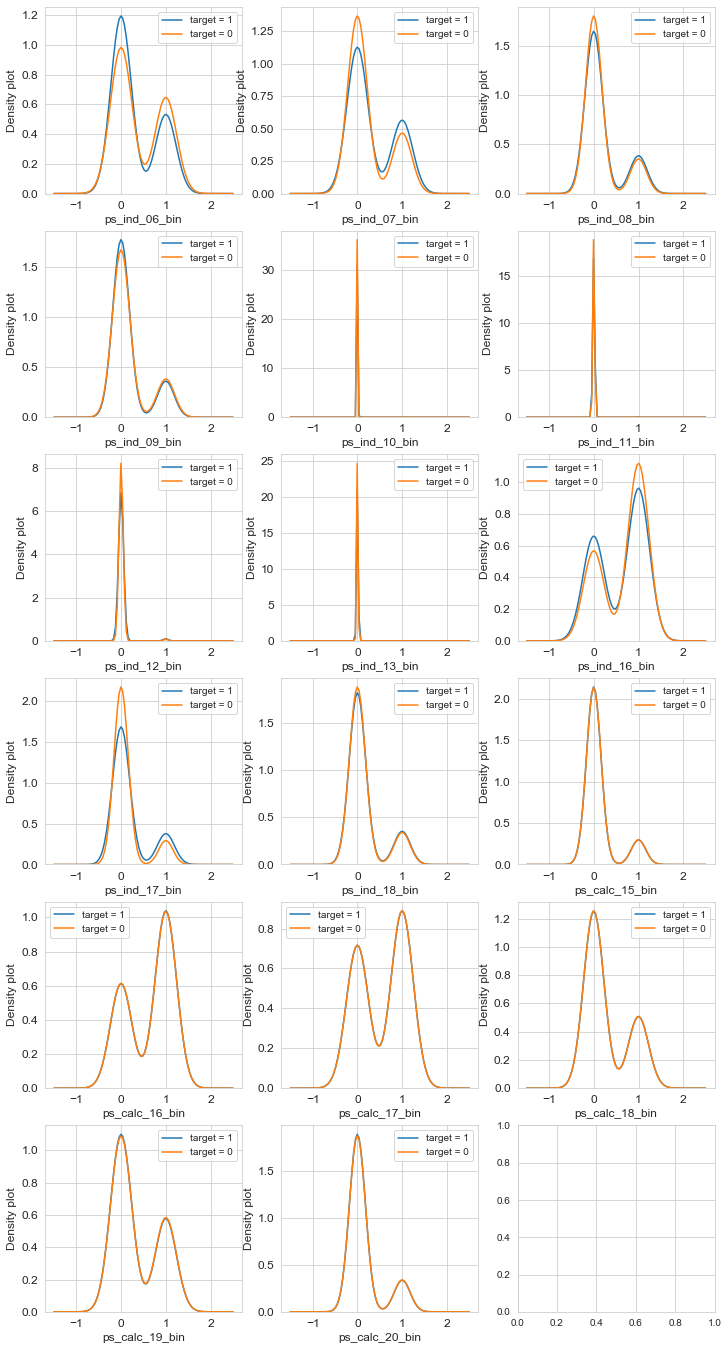

In [25]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Categorical features
------------

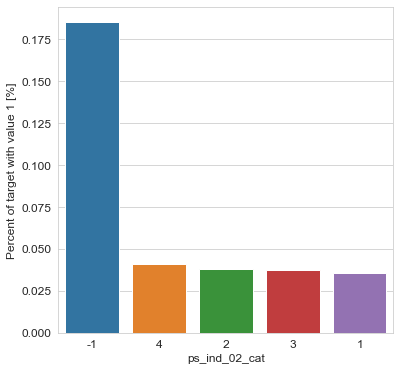

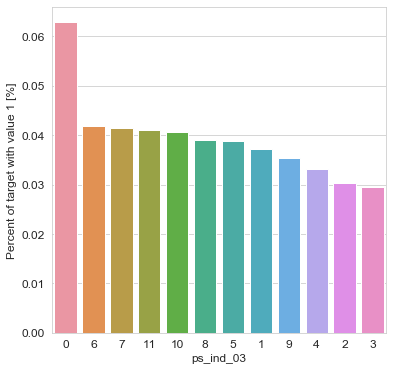

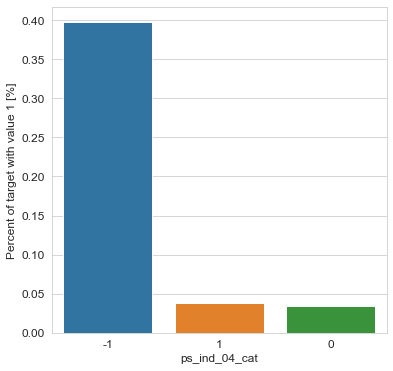

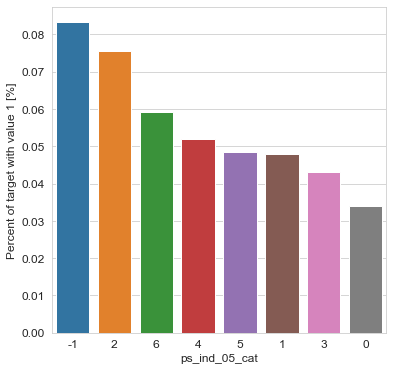

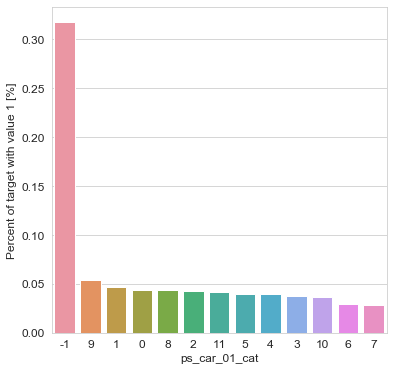

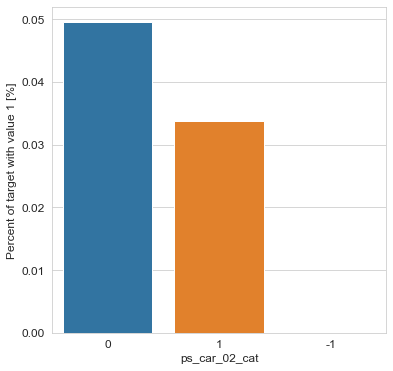

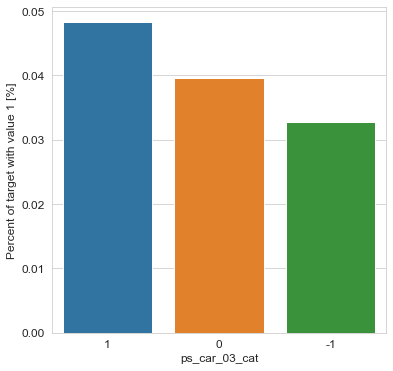

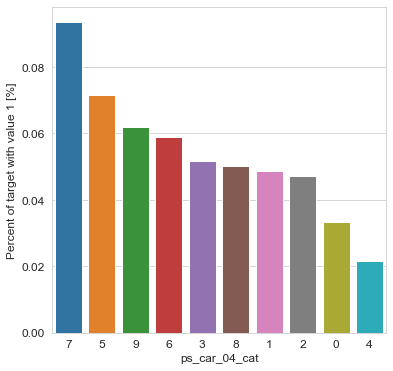

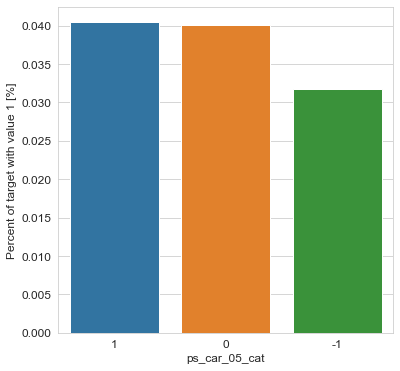

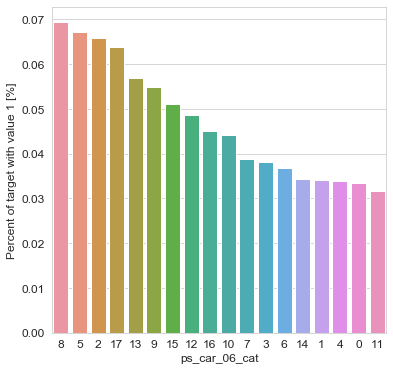

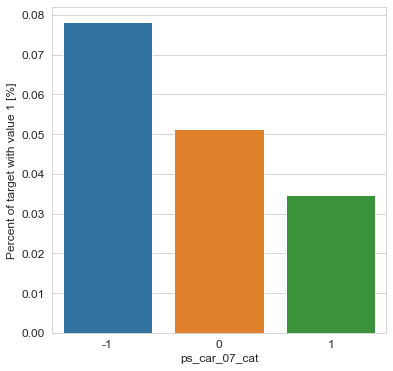

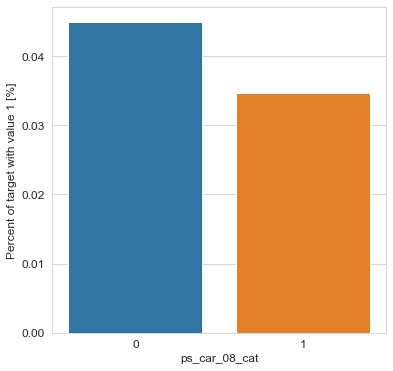

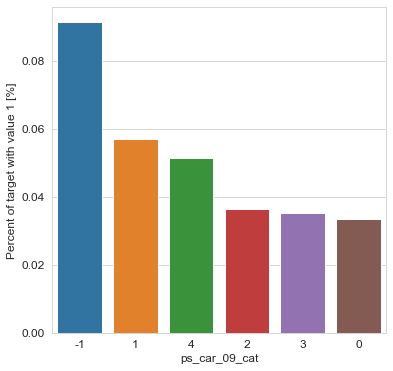

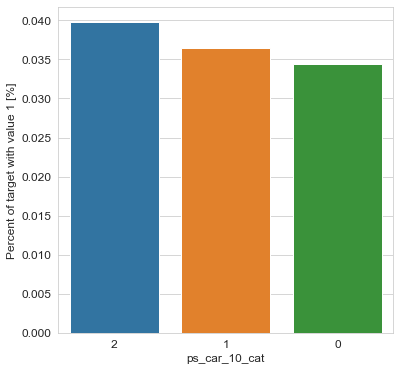

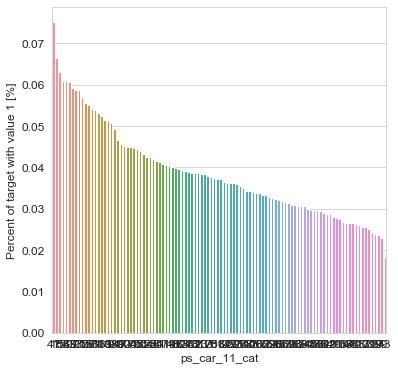

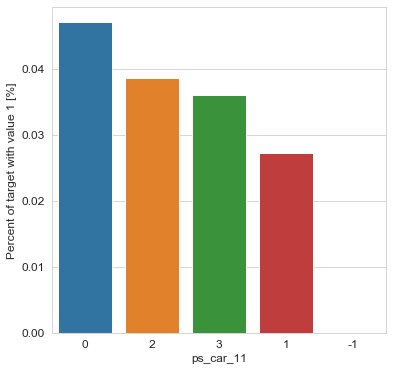

In [26]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();